# Modèle V4 de voiture autonome sur DonkeyCarSimulator

Cette version se veut la plus généraliste possible. Ce notebook fonctionne aussi bien sur Jupyter que sur Google Colab

In [ ]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
import json
from PIL import Image
import base64
from io import BytesIO
import inspect
from matplotlib import pyplot as plt

## Importer la dataset

### Google Drive

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!rm -Rf "corentin_renault_20000_record_controller"
!cp "drive/My Drive/ColabStorage/DonkeyCar/Simulator/Dataset/corentin_renault_20000_record_controller.eslr" "dataset.eslr"

### Autre source (CURL)

In [ ]:
!curl <LIEN_URL> --output dataset.eslr

## Configuration

In [ ]:
TIME = str(time())

### ENVIRONEMENT ###
STORAGE_ROOT_DIR = "drive/My Drive/ColabStorage/DonkeyCar/Simulator"

### INPUT ###
IMAGE_SHAPE = (120,160, 3)

### MODEL ###
MODEL_NAME = "DCDeepModelV4.0-reda-renault-speed_accel_gyro-" + TIME
SAVE_PATH = os.path.join(STORAGE_ROOT_DIR, "Model", MODEL_NAME)
os.makedirs(SAVE_PATH, exist_ok=True)

TENSORLOG_PATH = os.path.join(STORAGE_ROOT_DIR, "Trainer", "Log", MODEL_NAME)
os.makedirs(TENSORLOG_PATH, exist_ok=True)

BATCH_SIZE = 128

### DATASET ###
DATASET_NAME = "dataset"
DATASET_FILE_PATH = DATASET_NAME + ".eslr"

IMAGE_PATH = "images"
DATASET_LABEL_FILENAME = "label.csv"

DATASET_LABEL_PATH = os.path.join(DATASET_NAME, DATASET_LABEL_FILENAME)
DATASET_IMAGE_PATH = os.path.join(DATASET_NAME, IMAGE_PATH)

SPLIT_VALIDATION = 0.05
SPLIT_TEST = 0.05

print("Ok.")

Ok.


## Extraire la dataset

On convertit chaque ligne du fichier *.eslr envoyées par le serveur en :
- une image qui sera stockée dans le dossier `<DATASET_NAME>/<DATASET_IMAGE_PATH>`
- une ligne dans le csv label.csv avec toutes les infos (reliées à aux images par leur `path`)

In [ ]:
class ESLRExtractor:
  def __init__(self, eslr_path):
    self.eslr_path = eslr_path
    if not os.path.exists(self.eslr_path):
      raise Exception("ESLR File not found !")
  
  def extract(self, label_path, images_path, image_ext = ".jpeg"):
    # Créer le dossier qui contiendra toutes les images extraites du .eslr s'il n'existe pas
    os.makedirs(images_path, exist_ok=True)

    # Ouvrir le fichier label.csv
    label_file = open(label_path, "w")

    # Pour définir les en-têtes du fichier label, il faut lire au moins la première ligne
    # du fichier *.eslr
    label_head_is_defined = False

    # Lire le fichier eslr
    with open(self.eslr_path, "r") as dataset_file:
      for i, line in enumerate(tqdm(dataset_file)):
        data_line = json.loads(line)
        if (data_line["msg_type"] == "telemetry"):
          # Si le header n'a pas encore initialisé
          if not label_head_is_defined:
            label_head_list = list(data_line.keys())
            label_head_list.remove("msg_type")
            label_head_list.remove("image")
            label_head_list = ['path'] + label_head_list
            label_head_str = ",".join(label_head_list)
            # Écrire le header dans le CSV
            label_file.write(label_head_str + "\n")
            label_head_is_defined = True
          # Définir le path de l'image à enregistrer
          image_focused_path = os.path.join(images_path, str(i) + image_ext)
          data_line['path'] = image_focused_path
          # Lire, décoder et enregistrer l'image
          Image.open(BytesIO(base64.b64decode(data_line["image"]))).save(image_focused_path)
          # Ajouter toutes les données de la ligne lue dans un le CSV
          # Mettre 0 comme valeur par défaut si la valeur n'est pas trouvée dans data_line
          data_list_to_write = [str(data_line.get(k, 0)) for k in label_head_list]
          label_file.write(",".join(data_list_to_write) + "\n")
    label_file.close()
  
  @staticmethod
  def read_csv(images_path):
    return pd.read_csv(images_path)

In [ ]:
eslr_extractor = ESLRExtractor(DATASET_FILE_PATH)
eslr_extractor.extract(label_path = DATASET_LABEL_PATH, images_path = DATASET_IMAGE_PATH)
raw_data = eslr_extractor.read_csv(DATASET_LABEL_PATH)

20032it [00:27, 737.79it/s]


In [ ]:
raw_data

,path,steering_angle,throttle,speed,hit,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,gyro_w,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,cte,activeNode,totalNodes,on_road,progress_on_shortest_path,user_angle,user_throttle,user_brake
0,dataset/images/0.jpeg,0.00000,0.6,1.412430,none,192.1153,-0.062174,-0.641881,1.450789,-0.000518,0.000045,0.000194,1.000000,-64.98518,0.573791,-3.576344,-0.006630,0.292744,1.381743,0.021050,2,114,0,0,0.000000,0.600000,0
1,dataset/images/1.jpeg,0.00000,0.6,1.481240,none,192.1653,0.002470,-1.693349,1.271397,-0.001055,-0.000208,0.000208,1.000000,-64.98772,0.586890,-3.489104,-0.008594,0.209473,1.466329,0.018299,2,114,0,0,0.000000,0.600000,0
2,dataset/images/2.jpeg,0.00000,0.6,1.535611,none,192.2153,-0.008311,-2.115849,1.251322,-0.001270,0.000040,0.000190,0.999999,-64.98948,0.591905,-3.428022,-0.009827,0.127840,1.530249,0.016384,2,114,0,0,0.000000,0.600000,0
3,dataset/images/3.jpeg,0.00000,0.6,1.623194,none,192.2654,0.055655,-2.273581,2.125585,-0.001157,-0.000092,0.000131,0.999999,-64.99217,0.593465,-3.331817,-0.008900,-0.006838,1.623155,0.013450,2,114,0,0,0.000000,0.600000,0
4,dataset/images/4.jpeg,0.00000,0.6,1.673900,none,192.3154,0.040548,-2.003264,1.249415,-0.000676,0.000025,0.000086,1.000000,-64.99388,0.590875,-3.264349,-0.007723,-0.089862,1.671468,0.011573,2,114,0,0,0.000000,0.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20027,dataset/images/20027.jpeg,-0.64000,0.2,5.432403,none,1547.4660,0.150995,0.939248,-1.081991,0.000869,-0.008233,-0.001537,0.999965,12.10463,0.561794,0.338363,-0.351695,0.000074,5.421006,-0.090674,83,114,0,0,-1.003906,0.200000,0
20028,dataset/images/20028.jpeg,-0.64000,0.2,5.409408,none,1547.5670,-0.084162,0.476139,-5.112791,0.000483,-0.008904,-0.000755,0.999960,12.65098,0.562256,0.373596,-0.357141,0.020654,5.397566,-0.143633,83,114,0,0,-0.996063,0.200000,0
20029,dataset/images/20029.jpeg,-0.57254,0.2,5.451144,none,1547.6170,-0.365338,-0.053770,-3.966856,0.000155,-0.009262,0.000172,0.999957,12.86522,0.562933,0.403040,-0.354406,0.006789,5.439607,-0.180020,83,114,0,0,-0.345093,0.254907,0
20030,dataset/images/20030.jpeg,0.00000,0.6,5.475364,none,1547.6670,0.025925,-0.543784,3.724527,0.002143,-0.008837,0.001545,0.999958,13.18608,0.563562,0.458721,-0.321479,0.019962,5.465882,-0.246094,83,114,0,0,0.000000,0.600000,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9985fc81d0>,
      dtype=object)

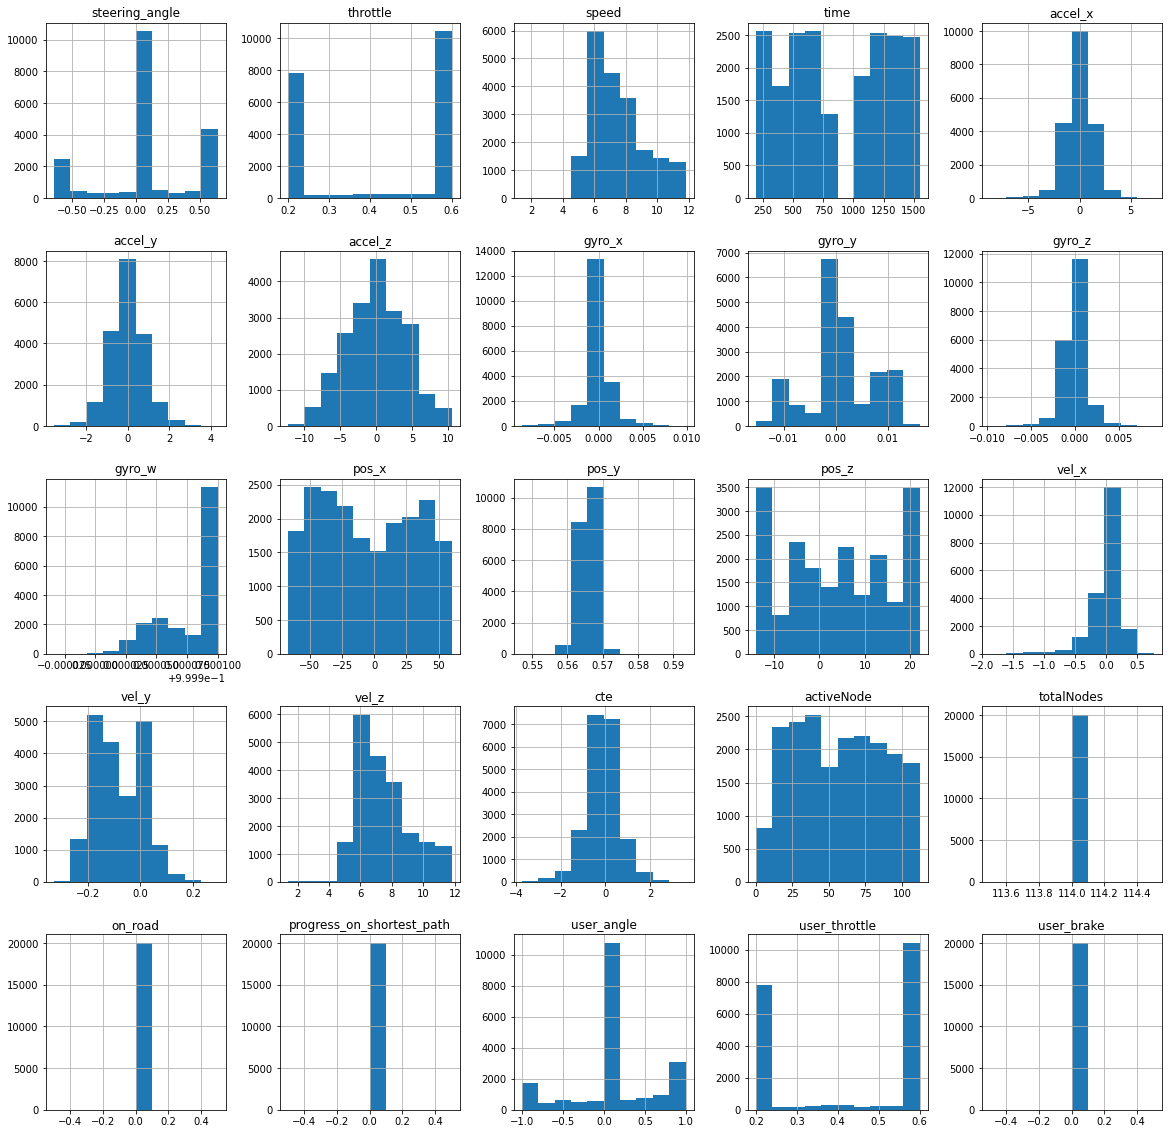

In [ ]:
raw_data.hist(figsize=(20,20))

## Préparer la dataset

### Split en 3 jeux : Train, Test et Validation

In [ ]:
train_and_test_set, validation_set = train_test_split(raw_data,
                                             test_size = SPLIT_VALIDATION,
                                             shuffle = True)
train_set, test_set = train_test_split(train_and_test_set,
                                             test_size = SPLIT_TEST,
                                             shuffle = True)

NBR_ROW_TRAIN_SET = train_set.shape[0]
NBR_ROW_TEST_SET = test_set.shape[0]
NBR_ROW_VALIDATION_SET = validation_set.shape[0]
print(train_set)
print(test_set)
print(validation_set)

                            path  steering_angle  ...  user_throttle  user_brake
19044  dataset/images/19044.jpeg        0.000000  ...       0.600000           0
16842  dataset/images/16842.jpeg        0.000000  ...       0.600000           0
19090  dataset/images/19090.jpeg        0.000000  ...       0.600000           0
548      dataset/images/548.jpeg        0.000000  ...       0.600000           0
18402  dataset/images/18402.jpeg        0.000000  ...       0.600000           0
...                          ...             ...  ...            ...         ...
3031    dataset/images/3031.jpeg        0.000000  ...       0.600000           0
8145    dataset/images/8145.jpeg        0.000000  ...       0.600000           0
12699  dataset/images/12699.jpeg        0.640000  ...       0.200000           0
3328    dataset/images/3328.jpeg       -0.478424  ...       0.200000           0
13012  dataset/images/13012.jpeg        0.000000  ...       0.458826           0

[18078 rows x 27 columns]
 

### Traitements avec TensorData

#### Donkey Car Data Augmentator

In [ ]:
class DonkeyCarDataAugmentator:
  @staticmethod
  def normalize(img):
    return (img / 127.5) - 1.0
  
  @staticmethod
  def unnormalize(img):
    return (img + 1.0) * 127.5

  @staticmethod
  def clip_image(img):
    return tf.clip_by_value(img, clip_value_min=0, clip_value_max=255)

  @staticmethod
  def noiser(img, mean, stddev):
    transformed_img = DonkeyCarDataAugmentator.normalize(img)
    noise_img = tf.random.normal(shape=tf.shape(img), mean=mean, stddev=stddev)
    transformed_img = tf.add(transformed_img, noise_img)
    transformed_img = DonkeyCarDataAugmentator.unnormalize(transformed_img)
    transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
    return transformed_img

  @staticmethod
  def transform(img, angle, ratio_augmentation = 0.75, ratio_flip_left_right = 0.5, max_brightness = 50,
                lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3):
    
    random_do_augmentation = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_augmentation <= ratio_augmentation:
      transformed_img = tf.image.random_brightness(img, max_delta = max_brightness)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      transformed_img = tf.image.random_contrast(transformed_img, lower = lower_contrast, upper = upper_contrast)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
      
      transformed_img = tf.image.random_saturation(transformed_img, lower = lower_saturation, upper = upper_saturation)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      random_noise_gain = tf.random.uniform(shape=[], minval = 0.0, maxval = max_noise, dtype=tf.float32)
      transformed_img = DonkeyCarDataAugmentator.noiser(transformed_img, mean_noise, random_noise_gain)
    else:
      transformed_img = img
    
    random_do_flip = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_flip <= ratio_flip_left_right:
      transformed_img = tf.image.flip_left_right(transformed_img)
      angle *= -1
    
    return transformed_img, angle

#### Donkey Car Tensor Builder

In [ ]:
class DonkeyCarTensorBuilder:
  def __init__(self, input_label = {'input':['path']}, output_label = {'angle':['user_angle']}, num_parallel_calls = 3, image_shape = (120, 160, 3)):
    self.input_label = input_label
    self.output_label = output_label
    
    self.num_parallel_calls = num_parallel_calls
    self.image_shape = image_shape
  
  def dataset_to_tensor(self, dataset):
    """
    {"input" : dataset['path'], "speed_accel_gyro" : dataset[['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']]}, {"angle" : dataset['angle']}
    :return: Tensor
    """
    input_dict = {}
    output_dict = {}

    # Inputs
    for k, l in self.input_label.items():
      if len(l) != 0:
        if len(l) == 1:
          input_dict[k] = dataset[l[0]]
        else:
          input_dict[k] = dataset[l]

    # Outputs
    for k, l in self.output_label.items():
      if len(l) != 0:
        if len(l) == 1:
          output_dict[k] = dataset[l[0]]
        else:
          output_dict[k] = dataset[l]
    return tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
  
  def load_image(self, dataset_tensor):
    def load_image_map_func(inputs, outputs):
      loaded_inputs = dict(inputs)

      img = tf.io.read_file(inputs['input'])
      img = tf.cast(tf.image.decode_jpeg(img, channels=3), dtype=tf.float32)
      img = tf.reshape(img, self.image_shape)
      loaded_inputs['input'] = img

      return loaded_inputs, outputs
    return dataset_tensor.map(load_image_map_func, num_parallel_calls = self.num_parallel_calls)
  
  def make_augmentation(self, dataset_tensor, ratio_augmentation = 0.5, ratio_flip_left_right = 0.5, max_brightness = 50,
                  lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                  upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3):
    def augmentation_map_func(inputs, outputs):
      transformed_inputs = dict(inputs)
      transformed_outputs = dict(outputs)
      img = inputs['input']
      angle = outputs['angle']

      transformed_img, transformed_angle = DonkeyCarDataAugmentator.transform(img, 
                                                                  angle = angle, 
                                                                  ratio_augmentation = ratio_augmentation, 
                                                                  ratio_flip_left_right = ratio_flip_left_right, 
                                                                  max_brightness = max_brightness,
                                                                  lower_contrast = lower_contrast, 
                                                                  upper_contrast = upper_contrast, 
                                                                  lower_saturation = lower_saturation, 
                                                                  upper_saturation = upper_saturation, 
                                                                  mean_noise = mean_noise, 
                                                                  max_noise = max_noise)

      transformed_img = tf.reshape(transformed_img, self.image_shape)
      transformed_inputs['input'] = transformed_img
      transformed_outputs['angle'] = transformed_angle
      return transformed_inputs, transformed_outputs
    return dataset_tensor.map(augmentation_map_func, num_parallel_calls = self.num_parallel_calls)
  
  def normalize_dataset(self, dataset_tensor):
    def normalize_map_func(inputs, outputs):
      transformed_inputs = dict(inputs)
      transformed_img = inputs['input']
      transformed_img = DonkeyCarDataAugmentator.normalize(transformed_img)
      transformed_img = tf.reshape(transformed_img, self.image_shape)
      transformed_inputs['input'] = transformed_img
      return transformed_inputs, outputs
    return dataset_tensor.map(normalize_map_func, num_parallel_calls = self.num_parallel_calls)


#### Préparer la dataset
Shape des IO, Convertir en Tensor, Preprocess, Augmentation possiblement

In [ ]:
### <<< CONFIG >>> ###
input_label = {'input':['path'], 'speed_accel_gyro':['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}
output_label = {'angle':['user_angle']}

tensor_builder = DonkeyCarTensorBuilder(input_label = input_label,
                                        output_label = output_label,
                                        num_parallel_calls = 3,
                                        image_shape = IMAGE_SHAPE)

# Transforme panda DataFrame en Tensor
train_tensor = tensor_builder.dataset_to_tensor(train_set)
test_tensor = tensor_builder.dataset_to_tensor(train_set)
validation_tensor = tensor_builder.dataset_to_tensor(train_set)

# Charger les images, i.e lire les path et stocker les images à la place
train_tensor = tensor_builder.load_image(train_tensor)
test_tensor = tensor_builder.load_image(test_tensor)
validation_tensor = tensor_builder.load_image(validation_tensor)

# Mélanger, répéter, faire des batch et activer le pré-traitement
# On répète train_tensor pour faire de l'augmentation
train_tensor = train_tensor.shuffle(NBR_ROW_TRAIN_SET).repeat(2) ### <<< CONFIG >>> (repeat) ###
test_tensor = test_tensor.shuffle(NBR_ROW_TEST_SET)
validation_tensor = validation_tensor.shuffle(NBR_ROW_VALIDATION_SET)

### <<< CONFIG >>> (comment or not) ###
# Augmentation
train_tensor = tensor_builder.make_augmentation(train_tensor, 
                                                ratio_augmentation = 0.5, 
                                                ratio_flip_left_right = 0.5, 
                                                max_brightness = 50,
                                                lower_contrast = 0.75, 
                                                upper_contrast = 1.5, 
                                                lower_saturation = 0.0, 
                                                upper_saturation = 2, 
                                                mean_noise = 0.0, 
                                                max_noise = 0.3)

# Normaliser les images
train_tensor = tensor_builder.normalize_dataset(train_tensor).batch(BATCH_SIZE).prefetch(2)
test_tensor = tensor_builder.normalize_dataset(test_tensor).batch(BATCH_SIZE).prefetch(2)
validation_tensor = tensor_builder.normalize_dataset(validation_tensor).batch(BATCH_SIZE).prefetch(2)

#### Afficher les images de la dataset
C'est pour voir l'augmentation a bien fonctionné

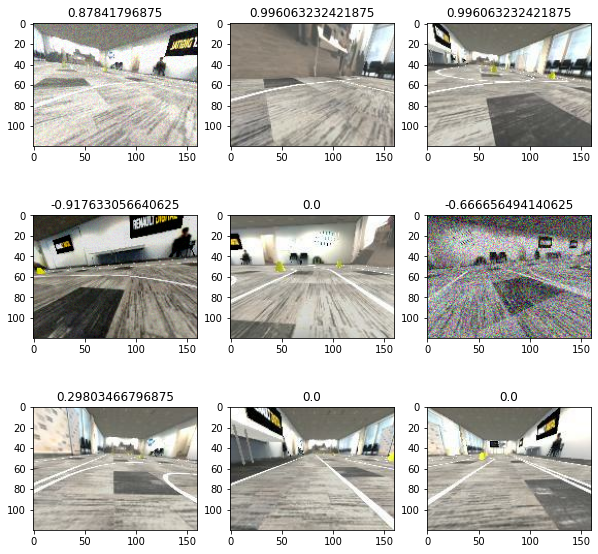

In [ ]:
plt.figure(figsize=(10, 10))
for i, o in train_tensor.take(1):
  img = DonkeyCarDataAugmentator.unnormalize(i['input'].numpy())
  for k in range(9):
    ax = plt.subplot(3, 3, k + 1)
    plt.imshow(img[k].astype("uint8"))
    plt.title(str(o['angle'][k].numpy()))

## Définir le modèle

### Définir ModelSaver

In [ ]:
class ModelSaver:
  """
  Save the model into a file ('model.code') as source code
  """
  def __init__(self, activate = True):
    """
    Initialize the saver
    :param activate: capture or not the source code of decorated functions
    """
    self.is_activated = activate
    self.s_init = None
    self.s_call = None
  def init(self, funct):
    """
    Capture the source code of the init function
    ---
    Use as a decoration
    Such as :
    ```
    MODEL_SAVER = ModelSaver(True)
    ...
    @MODEL_SAVER.init
    def __init__(self, name = ""):
      ...
    ```
    """
    def funct_with_params(*args, **kwargs):
      return funct(*args, **kwargs)
    if self.is_activated and self.s_init is None:
      self.s_init = inspect.getsource(funct)
    return funct_with_params

  def call(self, funct):
    """
    Capture the source code of the init function
    ---
    Use as a decoration
    Such as :
    ```
        MODEL_SAVER = ModelSaver(True)
        ...
        @MODEL_SAVER.call
        def call(self):
            ...
    ```
    """
    def funct_with_params(*args, **kwargs):
      return funct(*args, **kwargs)
    if self.is_activated and self.s_call is None:
      self.s_call = inspect.getsource(funct)
    return funct_with_params
  
  def save(self, path):
    """
    Save the source code of the model as a file
    :param path: file path
    """
    if self.s_init is not None and self.s_call is not None:
      with open(path, "w") as s:
        s.write("class DCModel(keras.Model):\n")
        s.write("  MODEL_SAVER = ModelSaver(False)\n")
        s.write(self.s_init)
        s.write(self.s_call)
    else:
      raise Exception("init or call function are not saved")
  @staticmethod
  def load(path):
    """
    Load the Model source code
    :param path: file path
    """
    with open(path, "r") as s:
      exec(s.read())

### Création du modèle

In [ ]:
LR = 0.00035

In [ ]:
MODEL_SAVER = ModelSaver(True)

class DCModel(keras.Model):
  @MODEL_SAVER.init
  def __init__(self, name="DCModel"):
    super(DCModel, self).__init__(name=name)
    #self.input_layer = keras.layers.Input(shape=IMAGE_SHAPE, name='input')
    self.cnn_1 = keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu', name='input')
    self.bn_1 = tf.keras.layers.BatchNormalization()

    self.cnn_2 = keras.layers.Conv2D(36, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_2 = keras.layers.BatchNormalization()

    self.cnn_3 = keras.layers.Conv2D(48, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_3 = keras.layers.BatchNormalization()

    self.cnn_4 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_4 = keras.layers.BatchNormalization()

    self.cnn_5 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_5 = keras.layers.BatchNormalization()

    self.drop_1 = keras.layers.Dropout(0.2)

    self.flat = keras.layers.Flatten()

    self.middle_input = keras.layers.Dense(7, name='speed_accel_gyro')
    self.bn_middle = keras.layers.BatchNormalization()
    self.merge = keras.layers.Concatenate()

    self.dense_1 = keras.layers.Dense(100, kernel_initializer='he_uniform', activation='elu')
    self.bn_6 = keras.layers.BatchNormalization()
    self.drop_2 = keras.layers.Dropout(0.1)

    self.dense_2 = keras.layers.Dense(50, kernel_initializer='he_uniform', activation='elu')
    self.bn_7 = keras.layers.BatchNormalization()
    self.drop_3 = keras.layers.Dropout(0.1)

    self.dense_3 = keras.layers.Dense(25, kernel_initializer='he_uniform', activation='elu')
    self.bn_8 = keras.layers.BatchNormalization()

    self.output_layer_1 = keras.layers.Dense(1, activation='linear', name='angle')
    #self.output_layer_2 = keras.layers.Dense(1, activation='linear', name='throttle')
  
  @MODEL_SAVER.call
  @tf.function
  def call(self, inputs, training=False):
    l = self.cnn_1(inputs['input'])
    l = self.bn_1(l)
    
    l = self.cnn_2(l)
    l = self.bn_2(l)

    l = self.cnn_3(l)
    l = self.bn_3(l)

    l = self.cnn_4(l)
    l = self.bn_4(l)

    l = self.cnn_5(l)
    l = self.bn_5(l)

    l = self.drop_1(l)

    l = self.flat(l)

    m = self.middle_input(inputs['speed_accel_gyro'])
    m = self.bn_middle(m)

    l = self.merge([l, m])

    l = self.dense_1(l)
    l = self.bn_6(l)
    l = self.drop_2(l)

    l = self.dense_2(l)
    l = self.bn_7(l)
    l = self.drop_3(l)

    l = self.dense_3(l)
    l = self.bn_8(l)
    
    return {'angle' : self.output_layer_1(l)}

model = DCModel(name='DonkeyCarModel')

optimizer = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer,loss=keras.losses.MSE, metrics=["mse"])

## Entraîner le modèle

In [ ]:
### <<< CONFIG >>> ###
INITIAL_EPOQUE = 0
NBR_EPOQUES = 1
NBR_EPOQUES_APRES_EARLY_STOPPING = 4

### <<< CONFIG >>> ###
"""
keras.callbacks.EarlyStopping(patience=NBR_EPOQUES_APRES_EARLY_STOPPING, restore_best_weights=True)


 keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)
"""
# Définir les callback
cb = [
        keras.callbacks.TensorBoard(log_dir=TENSORLOG_PATH)
     ]


"\nkeras.callbacks.EarlyStopping(patience=NBR_EPOQUES_APRES_EARLY_STOPPING, restore_best_weights=True)\n\n\n keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,\n                                    save_weights_only=True,\n                                    monitor='val_loss',\n                                    mode='min',\n                                    save_best_only=True)\n"

In [ ]:
# Entraîner le modèle
model.fit(train_tensor,
          validation_data = test_tensor,
          epochs = NBR_EPOQUES,
          initial_epoch = INITIAL_EPOQUE,
          callbacks=cb)

283/283 [==============================] - 59s 182ms/step - loss: 0.3148 - mse: 0.3148 - val_loss: 0.0425 - val_mse: 0.0425


## Sauvegarde le modèle

In [ ]:
# Ne fonctionne plus en l'état actuel avec les décorateurs de ModelSaver
# model.save(SAVE_PATH, save_format='tf')

In [ ]:
model.save_weights(os.path.join(SAVE_PATH, "weights.data"))
MODEL_SAVER.save(os.path.join(SAVE_PATH, "model.code"))

In [ ]:
print(MODEL_NAME)

DCDeepModelV4.0-reda-renault-speed_accel_gyro-1617717772.8070931


In [ ]:
model.summary()

Model: "DonkeyCarModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               multiple                  1824      
_________________________________________________________________
batch_normalization (BatchNo multiple                  96        
_________________________________________________________________
conv2d (Conv2D)              multiple                  21636     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  144       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  43248     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  192       
_________________________________________________________________
conv2d_2 (Conv2D)            multiple               

In [ ]:
#Tensorboad
%load_ext tensorboard
%tensorboard --logdir="drive/My Drive/ColabStorage/DonkeyCar/Simulator/Trainer/Log"

## Évaluer les performances
On n'évalue pas particulièrement bien les performances ici avec ça mais titrons le ainsi !

In [ ]:
performances = model.evaluate(validation_tensor, batch_size = BATCH_SIZE)
print(performances)

142/142 [==============================] - 9s 61ms/step - loss: 0.0425 - mse: 0.0425
[0.042489808052778244, 0.042489808052778244]


## Nettoyer l'environnement

In [ ]:
!rm -rf "dataset"
!rm -rf "dataset.eslr"